In [1]:
import numpy as np
import pandas as pd
from pyDOE import lhs  # Latin Hypercube Sampling
from scipy.optimize import newton
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from matplotlib import pyplot as plt
import os
from sklearn.model_selection import GroupShuffleSplit
from tensorflow.keras.optimizers import SGD


# Ensure reproducibility'
np.random.seed(42)
tf.random.set_seed(42)

# Define the range for material constants as per Table 1 in the paper
E_range = [60000e6, 210000e6]  # MPa
sigma_y_range = [90e6, 1000e6]  # MPa
c_range = [1e6, 250000e6]  # MPa
gamma_range = [0, 10000]
b_range = [1, 40]
Q_range = [1e6, 150e6]  # MPa

# Number of material samples (NLHS) and strain samples (NΔε)
NLHS = 500
NΔε = 1500

# Generate Latin Hypercube Sample for material constants
def generate_material_constants_lhs(num_samples):
    lhs_samples = lhs(10, samples=num_samples)
    E = lhs_samples[:, 0] * (E_range[1] - E_range[0]) + E_range[0]
    sigma_y = lhs_samples[:, 1] * (sigma_y_range[1] - sigma_y_range[0]) + sigma_y_range[0]
    c = lhs_samples[:, 2:5] * (c_range[1] - c_range[0]) + c_range[0]  # c1, c2, c3
    gamma = lhs_samples[:, 5:8] * (gamma_range[1] - gamma_range[0]) + gamma_range[0]  # gamma1, gamma2, gamma3
    b = lhs_samples[:, 8] * (b_range[1] - b_range[0]) + b_range[0]
    Q = lhs_samples[:, 9] * (Q_range[1] - Q_range[0]) + Q_range[0]
    return np.column_stack((E, sigma_y, c, gamma, b, Q))

# Generate strain history byappointment islamabad accumulating increments
def generate_strain_history(num_samples, lb, ub):
    strain_history = np.zeros(num_samples)
    cumulative_strain = 0  # Start with zero cumulative strain

    # First range: Accumulate small positive strain increments
    for i in range(300):
        increment = np.random.uniform(lb, ub)
        cumulative_strain += increment
        strain_history[i] = cumulative_strain

    # Second range: Accumulate negative strain increments
    for i in range(300, 900):
        increment = np.random.uniform(lb, ub)
        cumulative_strain -= increment
        strain_history[i] = cumulative_strain

    # Third range: Return to positive strain increments
    for i in range(900, num_samples):
        increment = np.random.uniform(lb, ub)
        cumulative_strain += increment
        strain_history[i] = cumulative_strain

    return strain_history


# Hooke's law (elastic predictor)
def elastic_predictor(eps, eps_p, E, sigma_k1, sigma_k2, sigma_k3, sigma_i, sigma_y):
    sigma_trial = E * (eps - eps_p)  # Trial stress
    back_stress = sigma_k1 + sigma_k2 + sigma_k3
    yield_function = np.abs(sigma_trial - back_stress) - (sigma_y + sigma_i)
    return sigma_trial, yield_function

# Update kinematic hardening rule
def update_kinematic_hardening(sigma_k, eps_p_dot, c, gamma):
    return (2.0 / 3.0) * c * eps_p_dot - gamma * sigma_k * np.abs(eps_p_dot)

# Update isotropic hardening rule
def update_isotropic_hardening(sigma_i, eps_p_dot, b, Q):
    return b * (Q - sigma_i) * np.abs(eps_p_dot)

# Return mapping algorithm
def return_mapping(eps, eps_p, sigma_trial, yield_function, sigma_k1, sigma_k2, sigma_k3, sigma_i, 
                   c1, c2, c3, gamma1, gamma2, gamma3, b, Q, E, sigma_y):
    if yield_function <= 0:
        # Elastic step
        return sigma_trial, eps_p, sigma_k1, sigma_k2, sigma_k3, sigma_i
    else:
        # Plastic corrector step
        def plastic_residual(delta_gamma):
            eps_p_dot = delta_gamma
            back_stress = sigma_k1 + sigma_k2 + sigma_k3
            sigma_updated = sigma_trial - E * delta_gamma
            yield_function_updated = np.abs(sigma_updated - back_stress) - (sigma_y + sigma_i + b * delta_gamma)
            return yield_function_updated

        try:
            delta_gamma = newton(plastic_residual, 1e-5, tol=1e-5, maxiter=50)  # Solve for plastic multiplier
        except RuntimeError:
            delta_gamma = 0.0  # If Newton-Raphson fails, assume no plastic deformation

        eps_p += delta_gamma
        sigma_k1 += update_kinematic_hardening(sigma_k1, delta_gamma, c1, gamma1)
        sigma_k2 += update_kinematic_hardening(sigma_k2, delta_gamma, c2, gamma2)
        sigma_k3 += update_kinematic_hardening(sigma_k3, delta_gamma, c3, gamma3)
        sigma_i += update_isotropic_hardening(sigma_i, delta_gamma, b, Q)

        # Final stress update
        sigma_updated = sigma_trial - E * delta_gamma
        return sigma_updated, eps_p, sigma_k1, sigma_k2, sigma_k3, sigma_i

# Generate dataset
def generate_dataset(lb, ub, num_material_samples, num_strain_samples=1500):
    material_constants = generate_material_constants_lhs(num_material_samples)
    strain_history = generate_strain_history(num_strain_samples, lb, ub)
    
    dataset = []  # To store the dataset

    for i in range(num_material_samples):
        E, sigma_y = material_constants[i, 0], material_constants[i, 1]
        c = material_constants[i, 2:5]
        gamma = material_constants[i, 5:8]
        b, Q = material_constants[i, 8], material_constants[i, 9]
        
        # Initialize state variables
        sigma_k1, sigma_k2, sigma_k3, sigma_i, eps_p = 0, 0, 0, 0, 0
        
        for eps in strain_history:
            # Elastic predictor
            sigma_trial, yield_function = elastic_predictor(eps, eps_p, E, sigma_k1, sigma_k2, sigma_k3, sigma_i, sigma_y)

            # Return mapping algorithm
            sigma_updated, eps_p, sigma_k1, sigma_k2, sigma_k3, sigma_i = return_mapping(
                eps, eps_p, sigma_trial, yield_function, sigma_k1, sigma_k2, sigma_k3, sigma_i, 
                c[0], c[1], c[2], gamma[0], gamma[1], gamma[2], b, Q, E, sigma_y
            )

            # Store the data
            back_stress = sigma_k1 + sigma_k2 + sigma_k3
            trial_phi = np.abs(sigma_trial - back_stress) - (sigma_y + sigma_i)
            dataset.append([
                E, sigma_y, c[0], gamma[0], c[1], gamma[1], c[2], gamma[2], 
                b, Q, trial_phi, eps, sigma_updated, np.abs(eps_p)
            ])

    return np.array(dataset)


# Save the dataset to a CSV file
def save_dataset_to_csv(dataset, filename="generated_dataset_training20.11.csv"):
    columns = [E, sigma_y, c[0],gamma[0], c[1],gamma[1], c[2],gamma[2],
                b, Q, trial_phi,
                strain,          # Strain
                stress_rm,    # Stress from Return Mapping
                plastic_strain]
    df = pd.DataFrame(dataset, columns=columns)
    df.to_csv(filename, index=False)
    print(f"Dataset saved to {filename}")

# Normalize the dataset
def normalize_dataset(data, scaler=None):
    if scaler is None:
        scaler = MinMaxScaler()
        normalized_data = scaler.fit_transform(data)
    else:
        normalized_data = scaler.transform(data)
    return normalized_data, scaler

# Split dataset into training and testing sets
def split_dataset(X, y):
    return train_test_split(X, y, test_size=0.2, random_state=42)

# Build the neural network
def build_model(input_dim):
    model = Sequential([
        Dense(10, input_dim=X_train.shape[1], activation='sigmoid'),
        #Dense(5, activation='sigmoid'),
        Dense(1, activation='linear')
    ])
    custom_adam = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=10e-8)
    model.compile(optimizer=SGD(), loss='mean_squared_error', metrics=['mae'])
    return model


AttributeError: module 'tensorflow._api.v1.random' has no attribute 'set_seed'

In [ ]:
# Plot training and validation loss
def plot_loss(history, filename='loss_curve.png'):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    #plt.savefig(filename)  # Save the plot as an image file
    #plt.close()  # Close the plot to avoid displaying it in the notebook
    #print(f"Loss curve saved as {filename}")

# Plot predicted vs original values
def plot_predicted_vs_actual(y_test, y_pred, filename='predicted_vs_actual.png'):
    plt.figure(figsize=(8, 6))
    plt.plot(y_test, label='Original Values', color='blue')
    plt.plot(y_pred, label='Predicted Values', color='red', linestyle='--')
    plt.xlabel('Sample index')
    plt.ylabel('Plastic Strain')
    plt.title('Predicted vs. Original Plastic Strain')
    plt.legend()
    plt.grid(True)
    plt.show()
    #plt.savefig('predicted_vs_actual')  # Save the plot as an image file
    #plt.close()  # Close the plot to avoid displaying it in the notebookLHSLHS
    #print(f"Plot saved as {'predicted_vs_actual'}")

In [ ]:
training = generate_dataset(lb=0.0001,ub=0.0002, num_material_samples=500)

In [2]:
training_normalized,scaler = normalize_dataset(training)

NameError: name 'normalize_dataset' is not defined

In [5]:
training_normalized.shape

(750000, 14)

In [6]:
columns = ['E', 'sigma_y', 'c[0]','gamma[0]', 'c[1]','gamma[1]', 'c[2]','gamma[2]','b', 'Q', 'trial_phi',
            'strain',          # Strain
            'stress_rm',    # Stress from Return Mapping
            'plastic_strain']
df = pd.DataFrame(training_normalized, columns=columns)

In [7]:
group_column = df['E']

# Initialize GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Split the data based on the group column
train_idx, test_idx = next(gss.split(df, groups=group_column))

# Split the DataFrame into training and testing sets
train_df = df.iloc[train_idx]
val_df = df.iloc[test_idx]

In [8]:
# Separate features and target
X_train, y_train = train_df[['E', 'sigma_y', 'c[0]','gamma[0]', 'c[1]','gamma[1]', 'c[2]','gamma[2]','b', 'Q', 'trial_phi']].values, train_df['plastic_strain'].values
X_val, y_val = val_df[['E', 'sigma_y', 'c[0]','gamma[0]', 'c[1]','gamma[1]', 'c[2]','gamma[2]','b', 'Q', 'trial_phi']].values, val_df['plastic_strain'].values

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))

In [9]:
# Batch and shuffle the datasets
BATCH_SIZE = 1000  # Adjust batch size as needed

train_dataset = train_dataset.shuffle(buffer_size=len(X_train)).batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)

In [10]:
model = build_model(X_train.shape[1])

# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',         # Monitor the validation loss
    patience=20,                # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True   # Restore model weights from the epoch with the best value of the monitored quantity
)

# Train the model with early stopping
print("Training the model...")
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=1000,             # Set a large number of epochs0.00890221
    #batch_size=1000,
    #validation_split=0.2, 
    callbacks=[early_stopping],  # Include the early stopping callback
    verbose=1
)

Training the model...
Epoch 1/1000


/home/uashfaq/anaconda3/envs/elasticity/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1504 - mae: 0.3081 - val_loss: 0.0878 - val_mae: 0.2529
Epoch 2/1000
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0879 - mae: 0.2538 - val_loss: 0.0851 - val_mae: 0.2500
Epoch 3/1000
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0855 - mae: 0.2513 - val_loss: 0.0833 - val_mae: 0.2481
Epoch 4/1000
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0837 - mae: 0.2496 - val_loss: 0.0821 - val_mae: 0.2468
Epoch 5/1000
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0828 - mae: 0.2487 - val_loss: 0.0812 - val_mae: 0.2458
Epoch 6/1000
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0818 - mae: 0.2476 - val_loss: 0.0805 - val_mae: 0.2451
Epoch 7/1000
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0812 - mae: 0.2469 - val_loss: 0.0800 - val_mae: 0.2445
Epoch 8/1000
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0808 - mae: 0.2465 - val_loss: 0.0796 - val_mae: 0.2440
Epoch 9/1000
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0746 - mae: 0.2344


Validation Loss: 0.07255800068378448, Validation Accuracy: 0.2302909940481186


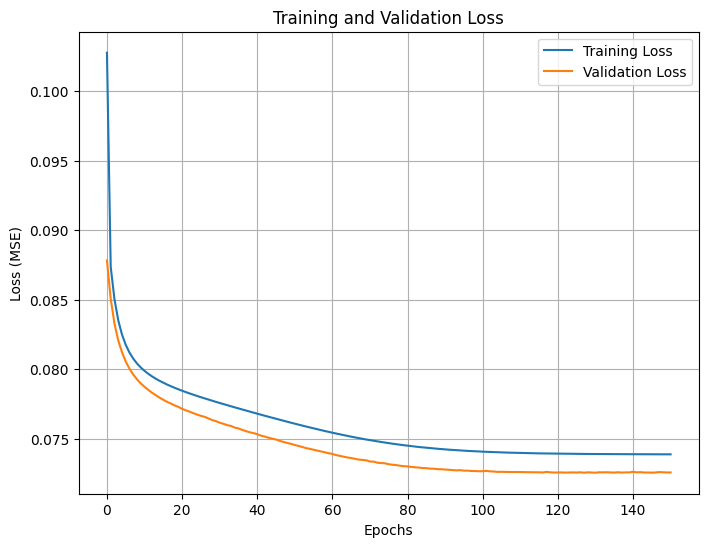

In [11]:
# Evaluate on validation set
val_loss, val_accuracy = model.evaluate(val_dataset)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

# Save the model
model.save('plastic_strain_predictor_model_21.11.h5')

# Plot training and validation loss
plot_loss(history, filename='loss_curve.png')

In [12]:
df_test= val_df[np.isclose(val_df['b'], 0.00890221,)]

In [13]:
X_test, y_test = df_test[['E', 'sigma_y', 'c[0]','gamma[0]', 'c[1]','gamma[1]', 'c[2]','gamma[2]','b', 'Q', 'trial_phi']].values, df_test['plastic_strain'].values

In [14]:
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [15]:
test_dataset = test_dataset.batch(BATCH_SIZE)

In [24]:
predictions = np.abs(model.predict(test_dataset))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [25]:
df_test.iloc[:,-1].values

array([0.        , 0.        , 0.        , ..., 0.91137152, 0.91527323,
       0.91886498])

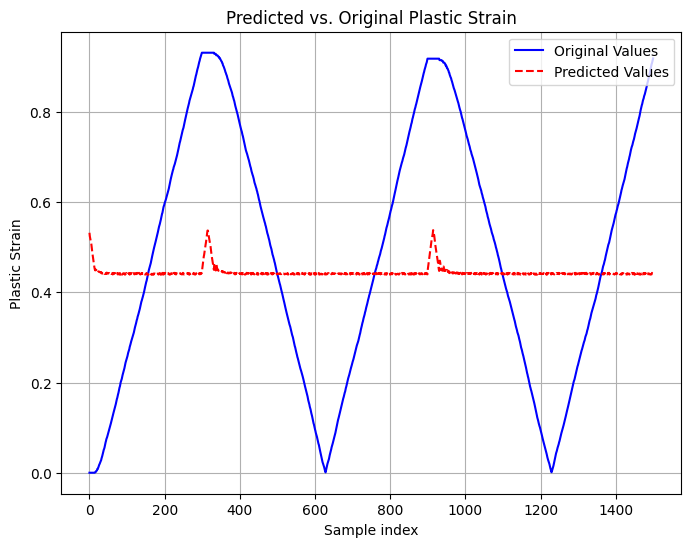

In [26]:
# Plot predicted vs original plastic strain
plot_predicted_vs_actual(df_test.iloc[:,-1].values, predictions, filename='predicted_vs_actual.png')

In [27]:
strain_values_test = df_test['strain']

In [28]:
y_pred_normalized_nn = np.squeeze(predictions)

In [29]:
stress_values_predicted =(strain_values_test - y_pred_normalized_nn)

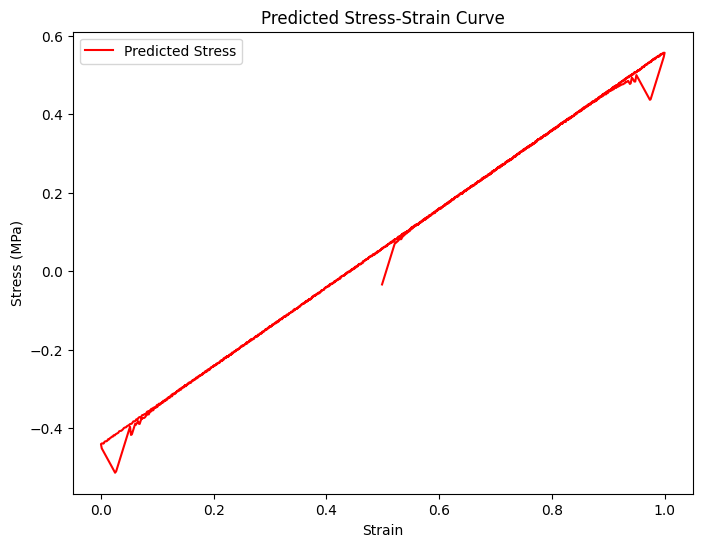

In [30]:
# Plot predicted stress vs strain
plt.figure(figsize=(8, 6))
plt.plot(strain_values_test, stress_values_predicted, label='Predicted Stress', color='red')
#plt.plot(strain_values_test, df_test['stress_rm'], label='Actual Stress', color='blue')
plt.xlabel('Strain')
plt.ylabel('Stress (MPa)')
plt.title('Predicted Stress-Strain Curve')
plt.legend()

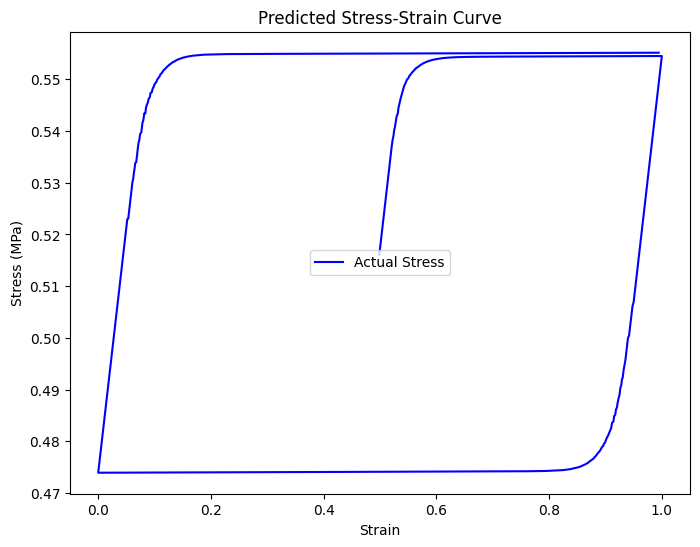

In [31]:
# Plot predicted stress vs strain
plt.figure(figsize=(8, 6))
#plt.plot(strain_values_test, stress_values_predicted, label='Predicted Stress', color='red')
plt.plot(strain_values_test, df_test['stress_rm'], label='Actual Stress', color='blue')
plt.xlabel('Strain')
plt.ylabel('Stress (MPa)')
plt.title('Predicted Stress-Strain Curve')
plt.legend()